In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import emcee
from scipy.integrate import quad

from StringIO import StringIO 
%matplotlib inline


In [2]:
data=pd.read_csv('continuousMock0.csv')
data.rename(columns={'r': 'radius2D'},inplace=True)
#data.radius2D = np.sqrt(np.power(data.x,2)+np.power(data.y,2))
data.describe()


,Unnamed: 0,radius2D,vobs
count,1004.000000,1004.000000,1004.000000
mean,501.500000,4.806908,-11.062708
std,289.974137,21.012073,472.705292
min,0.000000,0.076374,-1456.933237
25%,250.750000,1.035270,-308.669614
50%,501.500000,1.599509,-16.985919
75%,752.250000,3.117174,299.198409
max,1003.000000,488.391053,1787.588603


In [5]:
N_total =  data['vobs'].count()
print N_total

1004


In [4]:
# here created the grid cell boundaries for our entries 
def get_the_grid(arr):
    # 1D array
    # has to be sorted!!! 
    arr = np.array(arr)
    grid = (arr[1:]+arr[:-1])/2.
    #print grid.shape
    #print arr[:-1].shape
    grid = np.append(2.*arr[0]-grid[0], grid)
    grid = np.append(grid, 2.*arr[-1]-grid[-1])
    #grid = np.append(grid, 2.*arr[arr.shape[0]-1]-grid[-1])
    grid_low = grid[:-1]
    grid_up = grid[1:]
    return grid_low, grid_up                                                                                                                                                   

data = data.sort(['radius2D'])
grid_low, grid_up = get_the_grid(data['radius2D'])
if grid_low[0]<0:
    grid_low[0]=0.
#print grid_low.shape, grid_up.shape, data.radius2D.shape
data['dr_in']= grid_low
data['dr_out'] = grid_up
data = data.sort(['vobs'])
grid_low, grid_up = get_the_grid(data['vobs'])
data['dv_in']= grid_low
data['dv_out'] = grid_up
#data_vel_sort = data.sort(['v'])

In [8]:
data['z_range']  = np.sqrt(1000.**2 - np.power(np.array(data.radius2D),2))
data['drdv'] = (data.dr_out-data.dr_in)*(data.dv_out-data.dv_in)
#print data.v_gauss_sq

In [7]:
def dNdrdv(z, r2D, m, f, alpha, beta):
    u = np.power(r2D,2)+np.power(z,2)  
    return alpha*np.power(u,(f)/2.)*np.exp(beta*np.power(u,m))
def log_likelihood(params):
    alpha = np.sqrt(2.*np.pi)*np.array(data.radius2D)*params[2]/params[0]
    v_gauss_sq = np.power(data.vobs-params[4], 2)
    beta = -0.5*np.array(v_gauss_sq)/params[0]**2
    f = params[1]-params[3]
    dN = 2.*np.array([quad(dNdrdv, 0., z, args=(r2D, params[1], f, a, b), epsabs=1.49e-04, epsrel=1.49e-04) \
                      for z, r2D, a ,b in zip(np.array(data.z_range), np.array(data.radius2D), alpha, beta)])
    dNdet =  dN[:,0]*np.array(data.drdv)
    return -np.sum(dNdet)+np.sum(np.log(dNdet))


def log_posterior(params):
    if np.all(np.array(params[:4])>0):
        return log_likelihood(params)
    else:
        return -np.inf



In [14]:
sig_0_in = 1000. #400
m_in = 0.2  #0.1
nu_0_in = 11.52*N_total #3900
k_in = 3. #3.
nwalkers = 1000
ndim = 5
v_mean = data['vobs'].mean()

par_in = np.array([sig_0_in, m_in, nu_0_in, k_in, v_mean])
pp0 = np.transpose(np.array([np.random.normal(par, size=nwalkers) for par in par_in]).reshape((ndim, nwalkers)))
params = pp0
print params
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, threads=4)

[[  1.00020366e+03  -4.45435749e-01   1.15673974e+04   2.95294771e+00
   -1.17184622e+01]
 [  9.98960263e+02   7.61500287e-01   1.15651465e+04   3.48132295e+00
   -1.13830537e+01]
 [  1.00049017e+03   2.27436459e+00   1.15667261e+04   3.83449616e+00
   -1.20285978e+01]
 [  9.99547410e+02   9.55613497e-01   1.15648779e+04   4.36563737e+00
   -9.80685845e+00]
 [  1.00032669e+03  -7.48260537e-01   1.15669362e+04   2.68980831e+00
   -1.02627304e+01]
 [  1.00020498e+03  -7.87412692e-01   1.15672910e+04   1.90152230e+00
   -1.06794174e+01]
 [  9.99206312e+02   8.97983019e-01   1.15653839e+04   3.58643173e+00
   -1.02523465e+01]
 [  1.00115081e+03   5.09004380e-01   1.15641980e+04   1.84514102e+00
   -1.09208552e+01]
 [  9.99970424e+02  -1.20619125e-01   1.15673259e+04   2.41752251e+00
   -1.03933412e+01]
 [  1.00139397e+03   9.32784490e-01   1.15659108e+04   3.61014085e+00
   -1.01046329e+01]]


In [9]:
f = open("chain.dat", "w")
f.close()
sampler.reset()
for result in sampler.sample(p, iterations=4, storechain=False):
    position = result[0]
    f = open("chain.dat", "a")
    for k in range(position.shape[0]):
            for m in position[k].shape[0]:
                f.write(str(position[k][m])+"\t")
    f.close()




NameError: name 'p0' is not defined

In [10]:
import time
tic = time.clock()
sampler.reset()
s, prob, state = sampler.run_mcmc(params, 50)
toc = time.clock()
print toc-tic

2.16


/usr/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:288: UserWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg)
/usr/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:288: UserWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg)
/usr/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:288: UserWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg)
/usr/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:288: UserWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg)


In [11]:
print "Mean acceptance fraction:", np.mean(sampler.acceptance_fraction)

chain = sampler.flatchain # np.loadtxt('chain.dat')


Mean acceptance fraction: 0.2575


In [ ]:
print prob


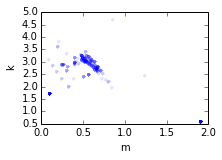

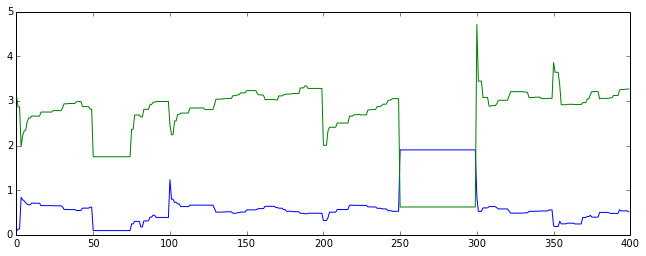

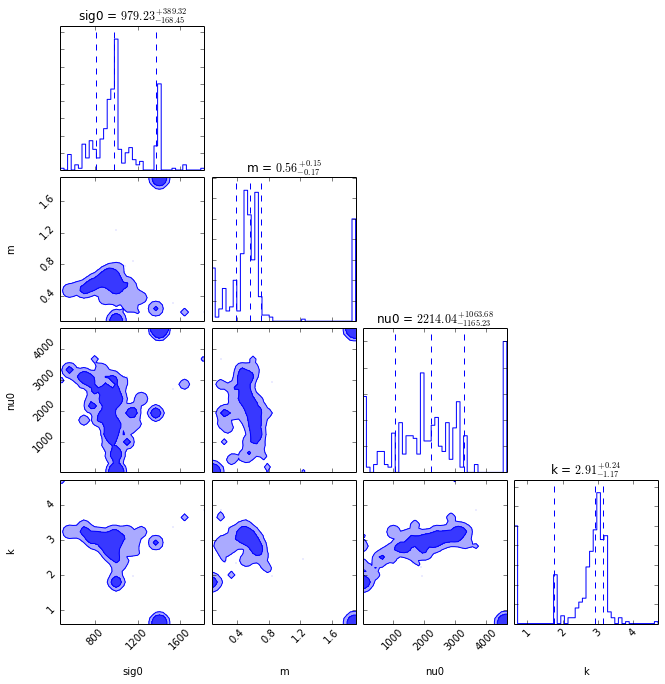

In [12]:
k_arr = [k for sig0, m, nu0, k in chain]
m_arr = [m for sig0, m, nu0, k in chain]

f = plt.figure(figsize=(3,2))
plt.clf()
plt.plot(m_arr, k_arr, 'b.', alpha=0.1)
plt.xlabel('m')
plt.ylabel('k')
f = plt.figure(figsize=(11,4))
plt.plot(m_arr, color='blue', label="m")
plt.plot(k_arr, color='green', label="k")
import corner
corner.corner(chain, labels=['sig0','m', 'nu0', 'k'], quantiles=[0.16,0.5,0.84],
                show_titles=True, title_args={"fontsize": 12},
                plot_datapoints=True, fill_contours=True, levels=[0.68, 0.95], color='b', bins=40, smooth=1.0);
plt.show()
